# Székely Dániel - JAXC3C

In [1]:
import numpy as np    # NumPy
import pandas as pd   # Pandas
%matplotlib inline    
import matplotlib.pyplot as plt # MatPlotLib

## Beolvasás

In [2]:
input_file="./busz-1.txt" # ez egy séta
data=pd.read_csv(input_file,sep=',')

In [3]:
print(data.columns)       # oszlopnevek

Index(['type', 'date time', 'latitude', 'longitude', 'accuracy(m)',
       'altitude(m)', 'geoid_height(m)', 'speed(m/s)', 'bearing(deg)',
       'sat_used', 'sat_inview', 'name', 'desc'],
      dtype='object')


In [4]:
data["tdat"]=pd.to_datetime(data['date time'], format="%Y-%m-%d %H:%M:%S")

## Előfeldolgozás

In [5]:
# Nem érdekel az abszolút idő, csak a kezdetektől eltelt:
tdat_arr=data.tdat.to_numpy()
t_arr=(tdat_arr-tdat_arr[0])/np.timedelta64(1, 's')  
# most t_arr-ban az első mérési ponttól eltelt idő van
print(t_arr[:5], "...", t_arr[-5:])

[0. 1. 2. 3. 4.] ... [604. 605. 606. 607. 608.]


In [6]:
# Földrajzi koordináták konvertálása x-y-ra
# Ez egy közelítő megoldás! 
# Addig jó  közelítés, amíg a pálya mérete sokkal kisebb a Föld sugaránál
# x: nyugatról keletre
# y: délről északra

R_F=6378000.0 # a Föld sugara m-ben

long_arr=np.radians(data.longitude).to_numpy()  # hosszúsági adatok radiánba
lat_arr=np.radians(data.latitude).to_numpy()    # szélességi adatok radiánba

# Most jön maga a konverzió. Origó: 0. mérési pont
# Képzeletben az x és y tengelyeket rágörbítjük a szélességi és hosszúsági körökre.
x_arr=(long_arr-long_arr[0])*np.cos(lat_arr[0])*R_F
y_arr=(lat_arr-lat_arr[0])*R_F



### Egy kis debug

In [7]:
# Néhány általános adat nyomtatása
print("Mérési pontok száma   : %d"%(len(t_arr)))

delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))

delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))

delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 609
Időtartam             : 608.00 s
Elmozdulás-komponensek: 1509.66 m, -2939.90 m
Elmozdulás nagysága   : 3304.86 m
Átlagsebesség-komponensek: 2.48 m/s, -4.84 m/s
Átlagsebesség nagysága   : 5.44 m/s


### Egyszerű megjelenítés

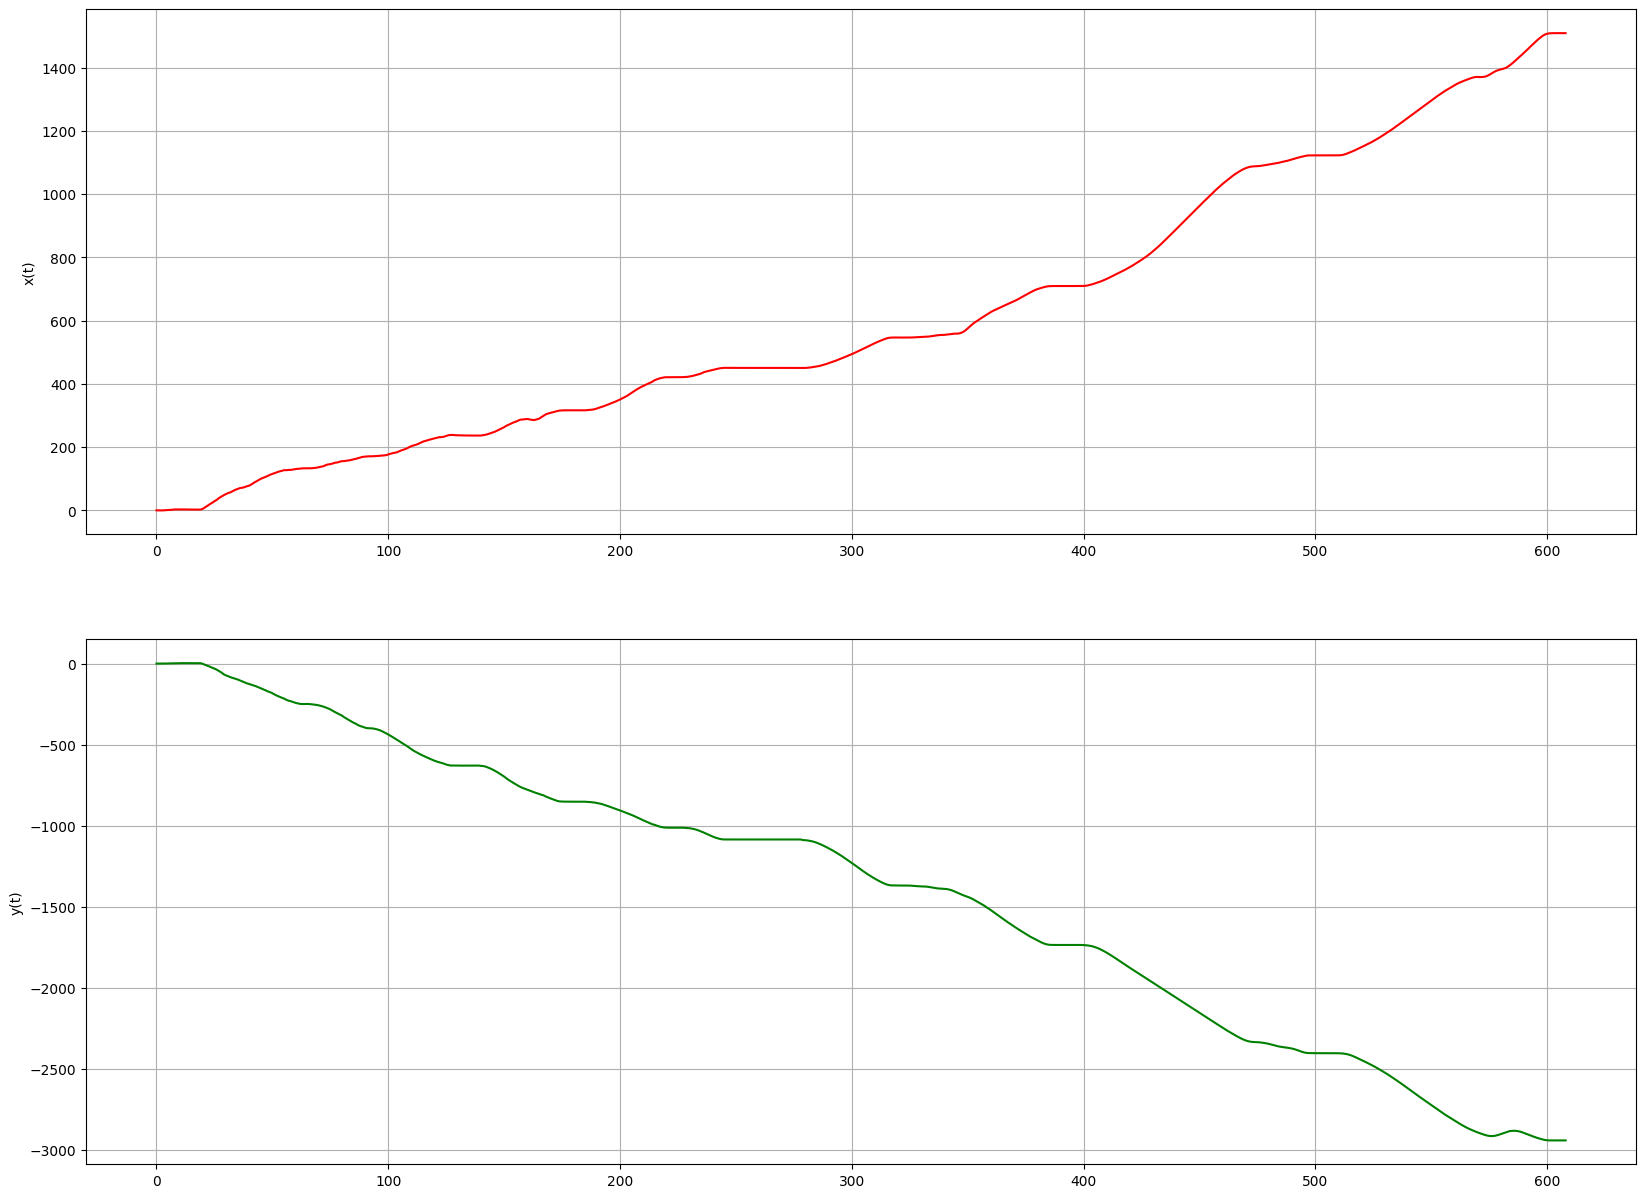

In [8]:
fig=plt.figure(figsize=(20,15))  # rajzméret
ax1=fig.add_subplot(211) # két rész-grafikon
ax2=fig.add_subplot(212)
ax1.set_ylabel("x(t)")
ax1.plot(t_arr, x_arr, color="red") # az elsőbe az x(t)
ax2.set_ylabel("y(t)")
ax2.plot(t_arr, y_arr, color="green") # a másodikba az y(t)
ax1.grid()
ax2.grid()

### Pályagörbe

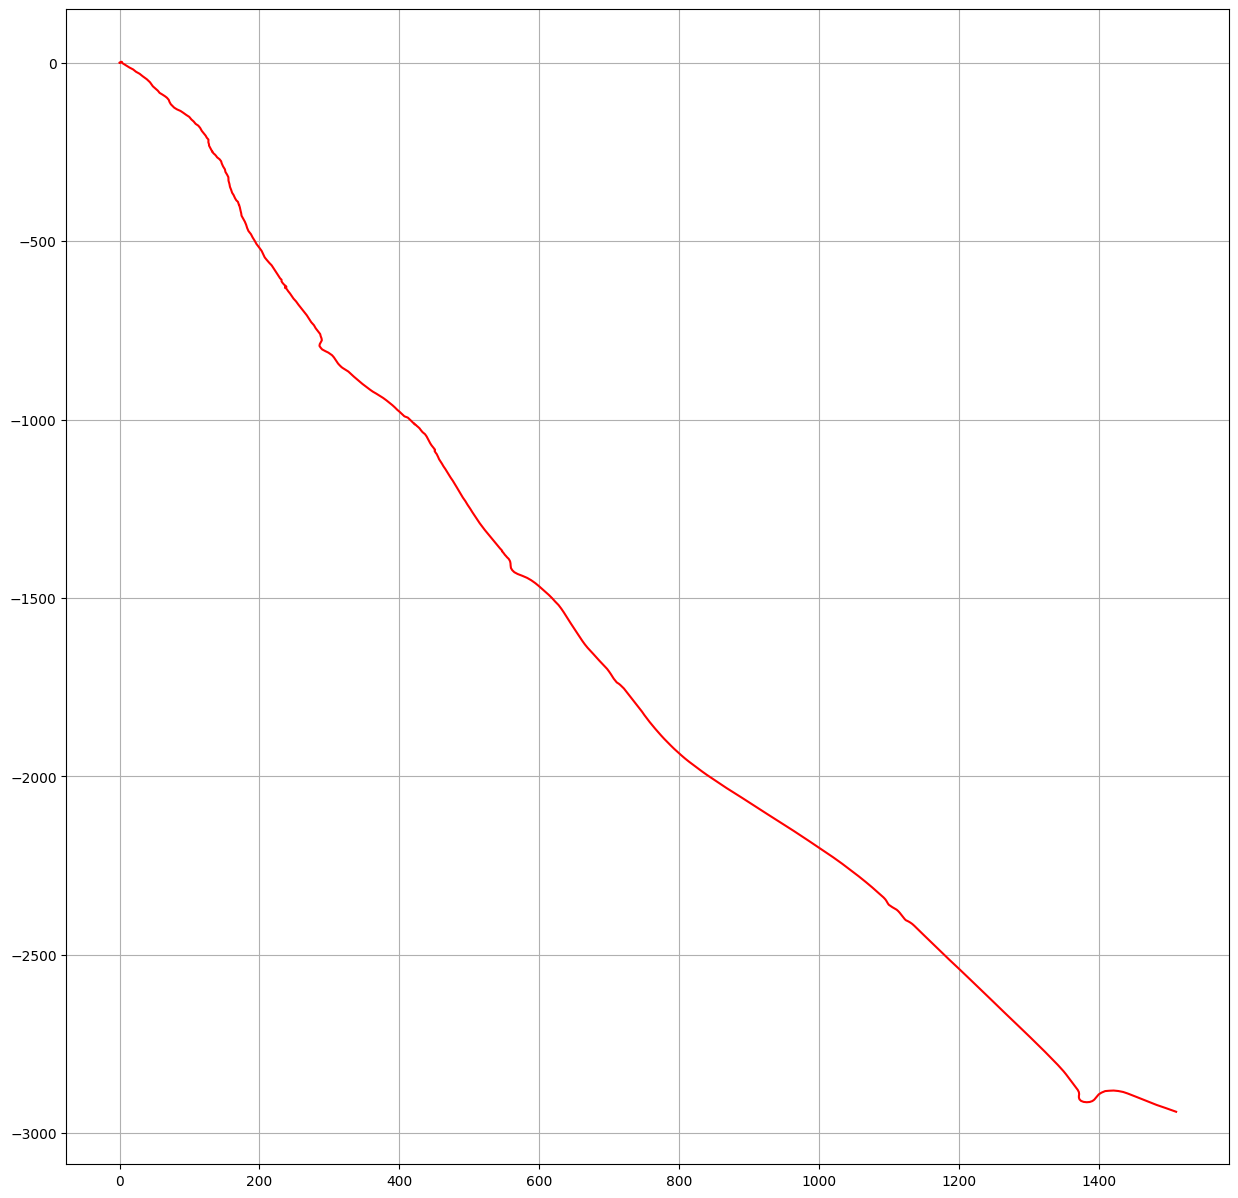

In [9]:
fig=plt.figure(figsize=(15,15))  # rajzméret
ax1=fig.add_subplot(111) 
ax1.plot(x_arr, y_arr, color="red") # x függvényében y
ax1.grid()

### Kinematikai számítások

In [10]:
def deriv(xx_tab, ff_tab):  # itt 'xx' az általános 'x' változót jelöli, nem az 'x' helykoordinátát!
    dff_dxx=np.zeros(xx_tab.shape, np.float64)
    dff_dxx[0]=(ff_tab[1]-ff_tab[0])/(xx_tab[1]-xx_tab[0]) # eleje
    dff_dxx[-1]=(ff_tab[-1]-ff_tab[-2])/(xx_tab[-1]-xx_tab[-2]) # vége
    dff_dxx[1:-1]=(ff_tab[2:]-ff_tab[0:-2])/(xx_tab[2:]-xx_tab[0:-2])  # közepe
    return(dff_dxx)

In [11]:
# sebesség-komponensek
vx_arr=deriv(t_arr, x_arr)
vy_arr=deriv(t_arr, y_arr)
# sebesség-nagyság:
vabs_arr=(vx_arr**2+vy_arr**2)**0.5

In [12]:
######################################################################
# Szorgalmi modifikáció - Székely Dániel - JAXC3C

# Megcsináltam a GPS-1-es feladatot akkor amikor még nem volt frissítve a moodle feladatleírás az újra.
# Ezért ha már egyszer azt is megcsináltam gondoltam bele rakom ebbe is.

#v_max = float(input("Enter v_max: ")/3.6)
v_max = 50/3.6

def higher_speed(v_speed, v_max):
    high_speed_duration = 0
    for v in v_speed:
        if v >= v_max:
            high_speed_duration += 1
    return high_speed_duration

def new_duration(v_speed, v_max, original_duration):
    new_v_speed = []
    for v in v_speed:
        if v > v_max:
            new_v_speed.append(v_max)
        else:
            new_v_speed.append(v)
    high_speed_duration = higher_speed(new_v_speed, v_max)
    new_duration = original_duration + high_speed_duration
    return new_duration


high_speed_duration = higher_speed(vabs_arr,v_max)
print(f"A mozgas sebesseg-nagysaga (> {v_max}) {high_speed_duration} masodpercig volt nagyobb")


new_duration = new_duration(vabs_arr, v_max, delta_t)
print(f"Az uj idotartam, ha korlatozzuk a sebesseget {v_max}-re valahanyszor meghaladja {v_max}-t akkor {new_duration} masodperc")

######################################################################

A mozgas sebesseg-nagysaga (> 13.88888888888889) 0 masodpercig volt nagyobb
Az uj idotartam, ha korlatozzuk a sebesseget 13.88888888888889-re valahanyszor meghaladja 13.88888888888889-t akkor 608.0 masodperc


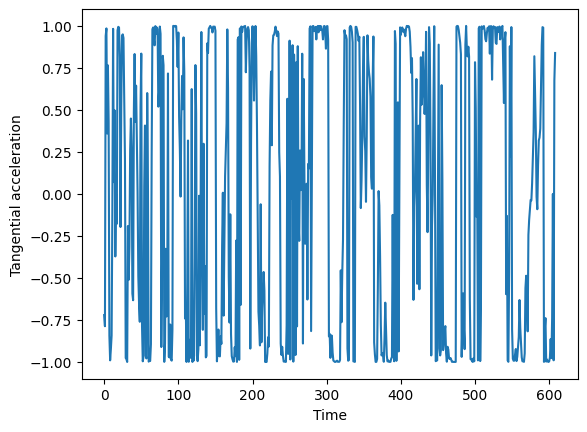

In [13]:
######################################################################
# Szorgalmi modifikáció - Székely Dániel - JAXC3C

def tangential_acceleration(x_arr, y_arr, t_arr):
    """
    A test tangenciális gyorsulása
    A mozgásirányban mekkora a gyorsulás, pozitív, ha nő a sebesség, negatív, ha csökken.
    """  
    vxs_arr= deriv(t_arr, x_arr)
    vys_arr= deriv(t_arr, y_arr)
    axs_arr= deriv(t_arr, vxs_arr)
    ays_arr= deriv(t_arr, vys_arr)

    vsabs_arr=(vxs_arr**2+vys_arr**2)**0.5
    as_abs_arr=(axs_arr**2+ays_arr**2)**0.5

    # a sebességvektor iránya:
    vxs_arr=vxs_arr/vsabs_arr
    vys_arr=vys_arr/vsabs_arr
    # a gyorsulásvektor iránya:
    axs_arr=axs_arr/as_abs_arr
    ays_arr=ays_arr/as_abs_arr
    # a tangenciális gyorsulás:
    txs_arr = vxs_arr*axs_arr+vys_arr*ays_arr
    return txs_arr

tangential_acc = tangential_acceleration(x_arr, y_arr, t_arr)

# Plot
plt.plot(t_arr, tangential_acc)
plt.xlabel('Time')
plt.ylabel('Tangential acceleration')
plt.show()

######################################################################


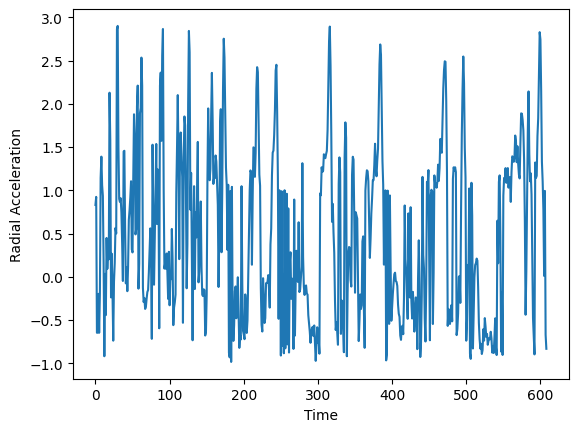

In [14]:
######################################################################
# Szorgalmi modifikáció - Székely Dániel - JAXC3C

def radial_acceleration(x_arr, y_arr, t_arr):
    """
    A test radiális gyorsulása.
    A mozgásirányra merőlegesen mekkora a gyorsulás.
    """   
    vxs_arr=deriv(t_arr, x_arr)
    vys_arr= deriv(t_arr, y_arr)
    axs_arr= deriv(t_arr, vxs_arr)
    ays_arr= deriv(t_arr, vys_arr)

    vsabs_arr=(vxs_arr**2+vys_arr**2)**0.5
    as_abs_arr=(axs_arr**2+ays_arr**2)**0.5
    # a sebességvektor irányvektora:
    vxs_arr=vxs_arr/vsabs_arr
    vys_arr=vys_arr/vsabs_arr
    # a gyorsulásvektor irányvektora:
    axs_arr=axs_arr/as_abs_arr
    ays_arr=ays_arr/as_abs_arr
    # a gyorsulásvektor és a sebességvektor skaláris szorzata:
    at_arr=axs_arr*vxs_arr+ays_arr*vys_arr
    # a radiális gyorsulás:
    ar_arr=as_abs_arr-at_arr
    return ar_arr

ar_arr = radial_acceleration(x_arr, y_arr, t_arr)

# Plot
plt.plot(t_arr, ar_arr)
plt.xlabel('Time')
plt.ylabel('Radial Acceleration')
plt.show()

######################################################################


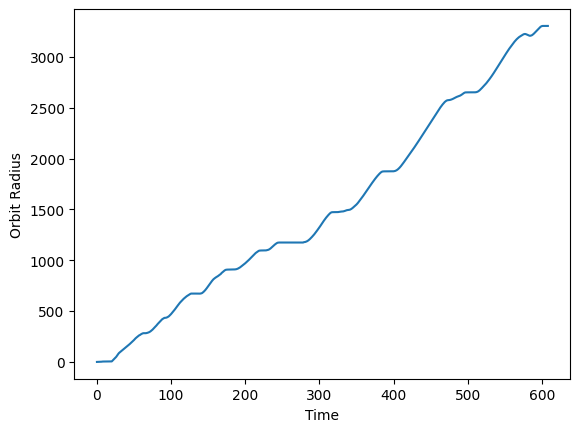

In [15]:
######################################################################
# Szorgalmi modifikáció - Székely Dániel - JAXC3C

def orbit_radius(x_arr, y_arr, t_arr):
    """
    A test pályájának sugara.
    """  
    vxs_arr=deriv(t_arr, x_arr)
    vys_arr= deriv(t_arr, y_arr)
    axs_arr= deriv(t_arr, vxs_arr)
    ays_arr= deriv(t_arr, vys_arr)

    vsabs_arr=(vxs_arr**2+vys_arr**2)**0.5
    as_abs_arr=(axs_arr**2+ays_arr**2)**0.5
    # a sebességvektor irányvektora:
    vxs_arr=vxs_arr/vsabs_arr
    vys_arr=vys_arr/vsabs_arr
    # a gyorsulásvektor irányvektora:
    axs_arr=axs_arr/as_abs_arr
    ays_arr=ays_arr/as_abs_arr
    # a gyorsulásvektor és a sebességvektor skaláris szorzata:
    at_arr=axs_arr*vxs_arr+ays_arr*vys_arr
    # a radiális gyorsulás:
    ar_arr=as_abs_arr-at_arr
    # a pálya:
    r_arr = (x_arr**2+y_arr**2)**0.5
    return r_arr

r_arr = orbit_radius(x_arr, y_arr, t_arr)

# Plot
plt.plot(t_arr, r_arr)
plt.xlabel('Time')
plt.ylabel('Orbit Radius')
plt.show()

######################################################################


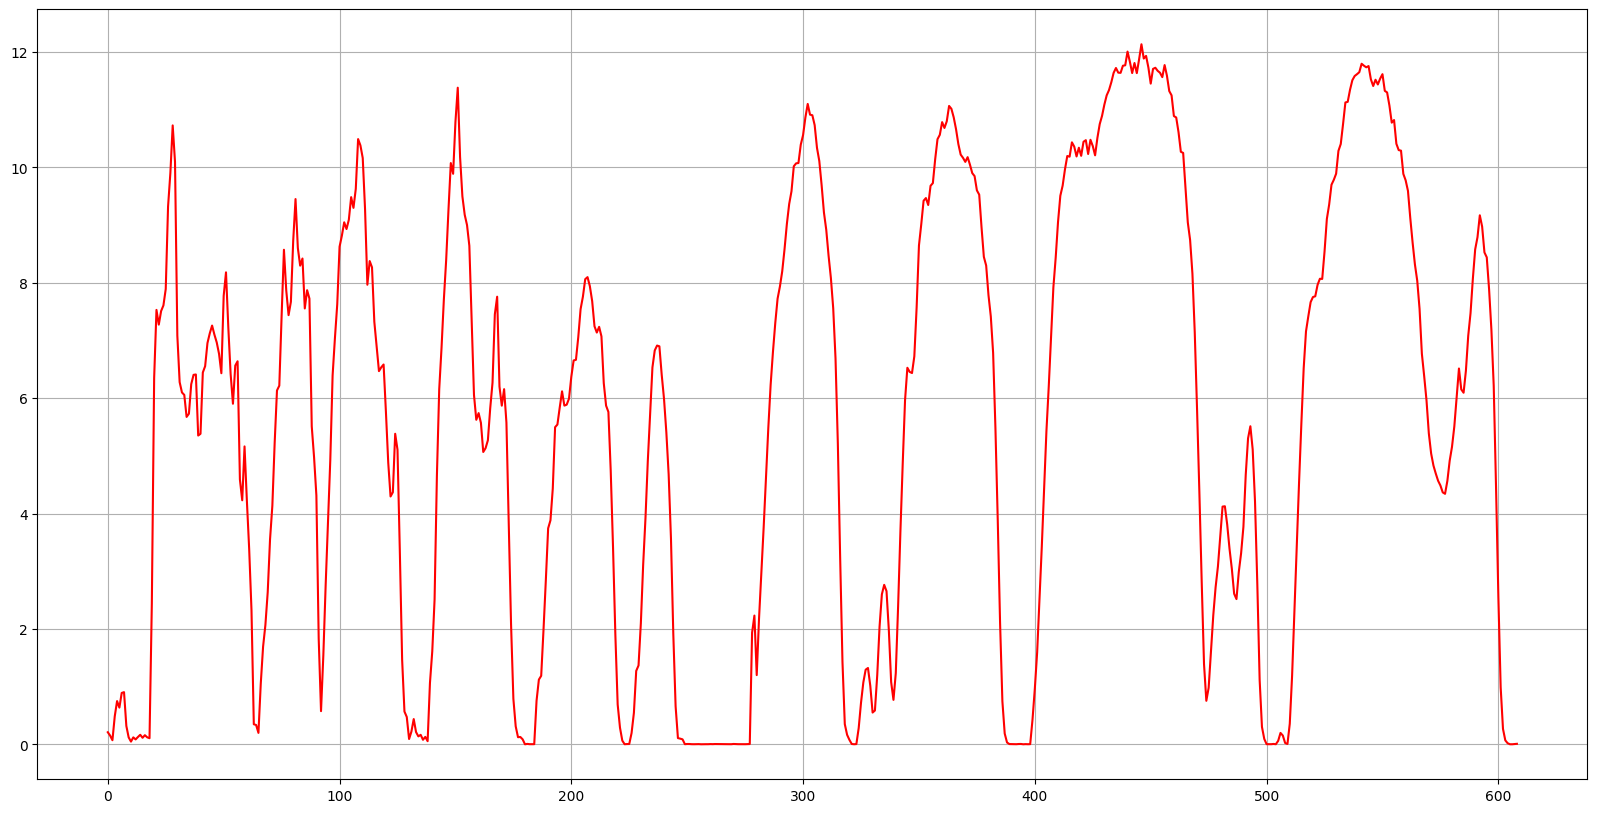

In [16]:
# hogyan alakult a sebesség nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, vabs_arr, color="red") 
ax1.grid()
# sok mérési adatsor esetén meglehetősen zajos lesz!

In [17]:
# út számítás
ut_arr=np.zeros(t_arr.shape, np.float64)
for i in range(1,len(ut_arr)):
    delta_x=x_arr[i]-x_arr[i-1]
    delta_y=y_arr[i]-y_arr[i-1]
    delta_ut=(delta_x**2+delta_y**2)**0.5
    ut_arr[i]=ut_arr[i-1]+ delta_ut

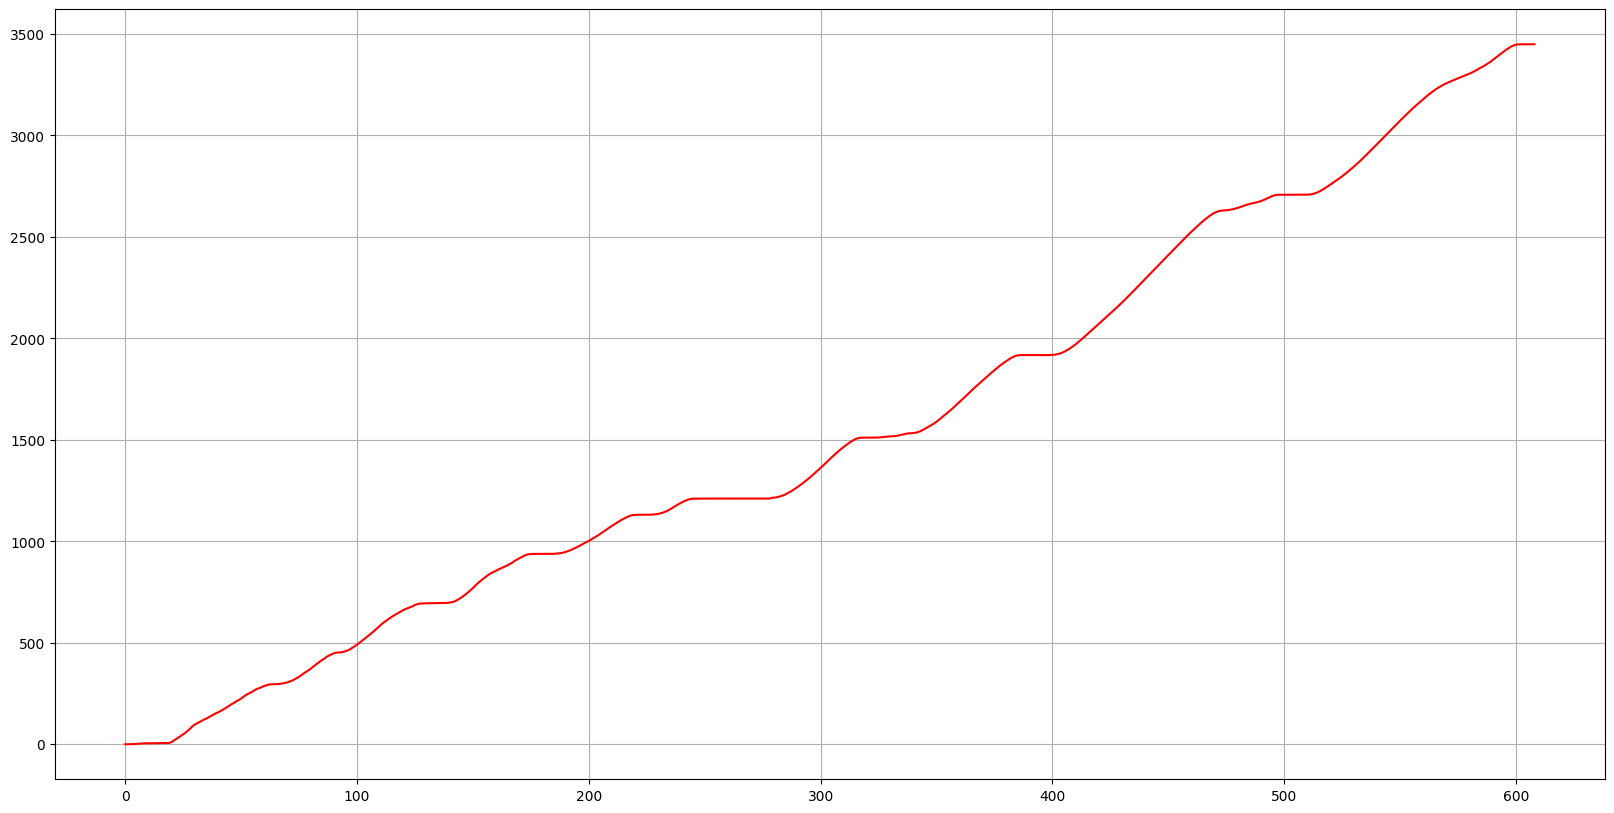

In [18]:
# hogyan alakult az eddig megtett út?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, ut_arr, color="red") 
ax1.grid()
# sokszor meglehetősen zajos lesz!

In [19]:
# teljes utat jellemző adatok:
print("Megtett út              : %.2f m"%(ut_arr[-1]))
print("Átlagos sebesség-nagyság: %0.2f m/s"%(ut_arr[-1]/t_arr[-1]))

Megtett út              : 3449.53 m
Átlagos sebesség-nagyság: 5.67 m/s


In [20]:
# néhány általános adat: (ismétlés)
print("Mérési pontok száma   : %d"%(len(t_arr)))
delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))
delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))
delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 609
Időtartam             : 608.00 s
Elmozdulás-komponensek: 1509.66 m, -2939.90 m
Elmozdulás nagysága   : 3304.86 m
Átlagsebesség-komponensek: 2.48 m/s, -4.84 m/s
Átlagsebesség nagysága   : 5.44 m/s


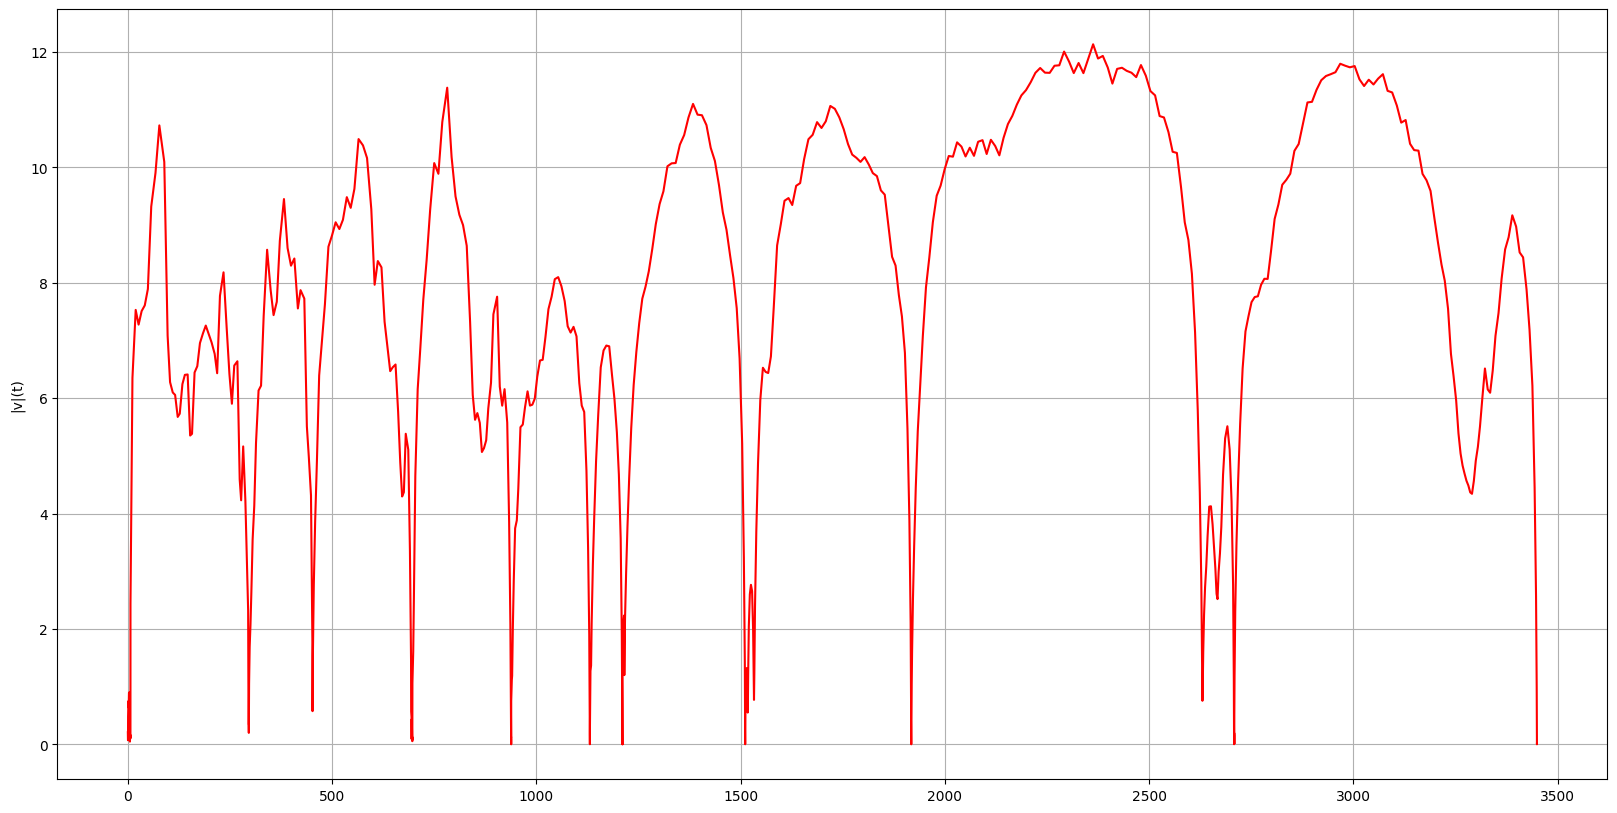

In [21]:
# Egy hasznos diagram: út függvényében a sebesség nagysága
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(ut_arr, vabs_arr, color="red") 
ax1.set_ylabel("|v|(t)")
ax1.grid()